In [ ]:
from dsc80_utils import *

# Lecture 13 – Linear Regression

## DSC 80, Fall 2023

## 📣 Announcements 📣

- Project 3 due tomorrow!
- Lab 7 out, due Monday, Nov 20.

## 📆 Agenda

- [ ] TF-IDF Example: State of the Union addresses 🎤.
- [ ] Modeling.
- [ ] Case study: Restaurant tips 🧑‍🍳.
- [ ] Regression in `sklearn`.


## 🙋🙋🏽‍♀️ Slido

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>




## Example: State of the Union addresses 🎤

### State of the Union addresses

The 2023 State of the Union address was on February 7th, 2023.

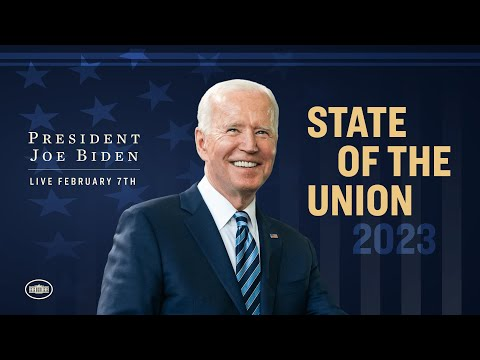

In [6]:
from IPython.display import YouTubeVideo
YouTubeVideo('gzcBTUvVp7M')

### The data

In [7]:
from pathlib import Path
import re

sotu_txt = Path('data') / 'stateoftheunion1790-2023.txt'
sotu = sotu_txt.read_text()
speeches = sotu.split('\n***\n')[1:]

def extract_struct(speech):
    L = speech.strip().split('\n', maxsplit=3)
    L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower()
    return dict(zip(['speech', 'president', 'date', 'contents'], L))

speeches_df = pd.DataFrame(list(map(extract_struct, speeches)))
speeches_df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
...,...,...,...,...
230,State of the Union Address,Joseph R. Biden Jr.,"April 28, 2021",thank you thank you thank you good to be b...
231,State of the Union Address,Joseph R. Biden Jr.,"March 1, 2022",madam speaker madam vice president and our ...
232,State of the Union Address,Joseph R. Biden Jr.,"February 7, 2023",mr speaker madam vice president our firs...


### Finding the most important words in each speech

Here, a "document" is a speech. We have 233 documents.

In [8]:
speeches_df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
...,...,...,...,...
230,State of the Union Address,Joseph R. Biden Jr.,"April 28, 2021",thank you thank you thank you good to be b...
231,State of the Union Address,Joseph R. Biden Jr.,"March 1, 2022",madam speaker madam vice president and our ...
232,State of the Union Address,Joseph R. Biden Jr.,"February 7, 2023",mr speaker madam vice president our firs...


A rough sketch of what we'll compute:

```
for each word t:
    for each speech d:
        compute tfidf(t, d)
```

In [9]:
unique_words = speeches_df['contents'].str.split().explode().value_counts()
# Take the top 500 most common words for speed
unique_words = unique_words.iloc[:500].index
unique_words

Index(['the', 'of', 'to', 'and', 'in', 'a', 'that', 'for', 'be', 'our',
       ...
       'desire', 'call', 'submitted', 'increasing', 'months', 'point', 'trust',
       'throughout', 'set', 'object'],
      dtype='object', length=500)

### 💡 Pro-Tip: Using `tqdm`

This code takes a while to run, so we'll use the `tdqm` package to track its progress. (Install with `pip install tqdm` if needed).

In [10]:
from tqdm.notebook import tqdm

tfidf_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()

# Wrap the sequence with `tqdm()` to display a progress bar
for word in tqdm(unique_words):
    re_pat = fr' {word} ' # Imperfect pattern for speed.
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf = np.log(len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum())
    tfidf_dict[word] =  tf * idf

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
tfidf = pd.DataFrame(tfidf_dict)
tfidf.head()

,the,of,to,and,...,trust,throughout,set,object
0,0.0,0.0,0.0,0.0,...,4.29e-04,0.00e+00,0.00e+00,2.04e-03
1,0.0,0.0,0.0,0.0,...,0.00e+00,0.00e+00,0.00e+00,1.06e-03
2,0.0,0.0,0.0,0.0,...,4.06e-04,0.00e+00,3.48e-04,6.44e-04
3,0.0,0.0,0.0,0.0,...,6.70e-04,2.17e-04,0.00e+00,7.09e-04
4,0.0,0.0,0.0,0.0,...,2.38e-04,4.62e-04,0.00e+00,3.77e-04


Note that the TF-IDFs of many common words are all 0!

### Summarizing speeches

By using `idxmax`, we can find the word with the highest TF-IDF in each speech.

In [13]:
tfidf

,the,of,to,and,...,trust,throughout,set,object
0,0.0,0.0,0.0,0.0,...,4.29e-04,0.00e+00,0.00e+00,2.04e-03
1,0.0,0.0,0.0,0.0,...,0.00e+00,0.00e+00,0.00e+00,1.06e-03
2,0.0,0.0,0.0,0.0,...,4.06e-04,0.00e+00,3.48e-04,6.44e-04
...,...,...,...,...,...,...,...,...,...
230,0.0,0.0,0.0,0.0,...,5.88e-05,1.71e-04,1.01e-04,0.00e+00
231,0.0,0.0,0.0,0.0,...,1.74e-04,1.13e-04,1.49e-04,0.00e+00
232,0.0,0.0,0.0,0.0,...,3.92e-04,0.00e+00,0.00e+00,0.00e+00


In [14]:
summaries = tfidf.idxmax(axis=1)
summaries

0          object
1      convention
2       provision
          ...    
230          it's
231       tonight
232          it's
Length: 233, dtype: object

What if we want to see the 5 words with the highest TF-IDFs, for each speech?

In [19]:
def five_largest(row):
    return list(row.index[row.argsort()][-5:])

In [20]:
keywords = tfidf.apply(five_largest, axis=1)

keywords_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords
], axis=1)
keywords_df

,president,date,0
0,George Washington,"January 8, 1790","[your, proper, regard, ought, object]"
1,George Washington,"December 8, 1790","[case, established, object, commerce, convention]"
2,George Washington,"October 25, 1791","[community, upon, lands, proper, provision]"
...,...,...,...
230,Joseph R. Biden Jr.,"April 28, 2021","[get, americans, percent, jobs, it's]"
231,Joseph R. Biden Jr.,"March 1, 2022","[let, jobs, americans, get, tonight]"
232,Joseph R. Biden Jr.,"February 7, 2023","[down, percent, jobs, tonight, it's]"


Run the cell below to see every single row of `keywords_df`.

In [21]:
display_df(keywords_df, rows=233)

,president,date,0
0,George Washington,"January 8, 1790","[your, proper, regard, ought, object]"
1,George Washington,"December 8, 1790","[case, established, object, commerce, convention]"
2,George Washington,"October 25, 1791","[community, upon, lands, proper, provision]"
3,George Washington,"November 6, 1792","[subject, upon, information, proper, provision]"
4,George Washington,"December 3, 1793","[having, vessels, executive, shall, ought]"
5,George Washington,"November 19, 1794","[too, army, let, ought, constitution]"
6,George Washington,"December 8, 1795","[army, prevent, object, provision, treaty]"
7,George Washington,"December 7, 1796","[republic, treaty, britain, ought, object]"
8,John Adams,"November 22, 1797","[spain, british, claims, treaty, vessels]"
9,John Adams,"December 8, 1798","[st, minister, treaty, spain, commerce]"


### Aside: What if we remove the $\log$ from $\text{idf}(t)$?

Let's try it and see what happens.

In [22]:
tfidf_nl_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()

for word in tqdm(unique_words):
    re_pat = fr' {word} ' # Imperfect pattern for speed.
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    # No np.log!
    idf_nl = len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum()
    tfidf_nl_dict[word] =  tf * idf_nl

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
tfidf_nl = pd.DataFrame(tfidf_nl_dict)
tfidf_nl.head()

,the,of,to,and,...,trust,throughout,set,object
0,0.09,0.06,0.05,0.04,...,1.47e-03,0.00e+00,0.00e+00,5.78e-03
1,0.09,0.06,0.03,0.03,...,0.00e+00,0.00e+00,0.00e+00,2.99e-03
2,0.11,0.07,0.04,0.03,...,1.39e-03,0.00e+00,1.30e-03,1.82e-03
3,0.09,0.07,0.04,0.03,...,2.29e-03,7.53e-04,0.00e+00,2.01e-03
4,0.09,0.07,0.04,0.02,...,8.12e-04,1.60e-03,0.00e+00,1.07e-03


In [24]:
keywords_nl = tfidf_nl.apply(five_largest, axis=1)
keywords_nl_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords_nl
], axis=1)
keywords_nl_df

,president,date,0
0,George Washington,"January 8, 1790","[a, and, to, of, the]"
1,George Washington,"December 8, 1790","[in, and, to, of, the]"
2,George Washington,"October 25, 1791","[a, and, to, of, the]"
...,...,...,...
230,Joseph R. Biden Jr.,"April 28, 2021","[of, it's, and, to, the]"
231,Joseph R. Biden Jr.,"March 1, 2022","[we, of, to, and, the]"
232,Joseph R. Biden Jr.,"February 7, 2023","[a, of, and, to, the]"


### The role of $\log$ in $\text{idf}(t)$

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{# of occurrences of $t$ in $d$}}{\text{total # of words in $d$}} \cdot \log \left(\frac{\text{total # of documents}}{\text{# of documents in which $t$ appears}} \right) \end{align*} $$
- Remember, for any positive input $x$, $\log(x)$ is (much) smaller than $x$.
- In $\text{idf}(t)$, the $\log$ "dampens" the impact of the ratio $\frac{\text{# documents}}{\text{# documents with $t$}}$.

- If a word is very common, the ratio will be close to 1. The log of the ratio will be close to 0.

In [25]:
# A word like "the" might appear in 999 out of 1000 documents
1000 / 999

1.001001001001001

In [26]:
np.log(1000 / 999)

0.001000500333583622

- If a word is very common (e.g. 'the'), removing the log multiplies the statistic by a large factor.
- If a word is very rare, the ratio will be very large. However, for instance, a word being seen in **2 out of 50** documents is not very different than being seen in **2 out of 500** documents (it is very rare in both cases), and so $\text{idf}(t)$ should be similar in both cases.

In [29]:
np.log(50 / 2)

3.2188758248682006

In [30]:
np.log(500 / 2)

5.521460917862246

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

## Modeling

<center><img src='imgs/ds-lifecycle.svg' width=50%></center>

### Reflection

So far this quarter, we've learned how to:

- Extract information from tabular data using `pandas` and regular expressions.
- Clean data so that it best represents a data generating process.
    - Missingness analyses and imputation.
- Collect data from the internet through scraping and APIs, and parse it using BeautifulSoup.
- Perform exploratory data analysis through aggregation, visualization, and the computation of summary statistics like TF-IDF.
- Infer about the relationships between samples and populations through hypothesis and permutation testing.
- **Now, let's make predictions.**

### Modeling

* **Data generating process**: A real-world phenomena that we are interested in studying.
    - *Example:* Every year, city employees are hired and fired, earn salaries and benefits, etc.
    - Unless we work for the city, we can't observe this process directly.

* **Model**: A theory about the data generating process.
    - *Example:* If an employee is $X$ years older than average, then they will make \$100,000 in salary.

* **Fit Model**: A model that is learned from a particular set of observations, i.e. training data.
    - *Example:* If an employee is 5 years older than average, they will make \$100,000 in salary.
    - How is this estimate determined? What makes it "good"?

### Goals of modeling

1. To make accurate **predictions** regarding **unseen data** drawn from the data generating process.

    - Given this dataset of past UCSD data science students' salaries, can we predict your future salary? (regression)
    - Given this dataset of images, can we predict if this new image is of a dog, cat, or zebra? (classification)
    
2. To make **inferences** about the structure of the data generating process, i.e. to understand complex phenomena.

    - Is there a linear relationship between the heights of children and the heights of their biological mothers?
    - The weights of smoking and non-smoking mothers' babies babies in my _sample_ are different – how _confident_ am I that this difference exists in the _population_?

<center><img src='imgs/ml-taxonomy.svg' width=100%></center>

- Of the two focuses of models, we will focus on **prediction**.

- In the above taxonomy, we will focus on **supervised learning**.

### Features

- A **feature** is a measurable property of a phenomenon being observed.
    - Other terms for "feature" include "(explanatory) variable" and "attribute".
    - Typically, features are the _inputs_ to models.

- In DataFrames, features typically correspond to **columns**, while rows typically correspond to different individuals.

* There are two types of features:
    * Features that come as part of a dataset, e.g. weight and height.
    * Features that we **create**, e.g. $\text{BMI} = \frac{\text{weight (kg)}}{\text{[height (m)]}^2}$.

- Example: TF-IDF creates **features** that summarize documents!

## Example: Restaurant tips 🧑‍🍳

### About the data

What features does the dataset contain?

In [31]:
# The dataset is built into plotly (and seaborn)!
tips = px.data.tips()
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
...,...,...,...,...,...,...,...
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


### Predicting tips

- **Goal:** Given various information about a table at a restaurant, we want to predict the **tip** that a server will earn.

- **Why** might a server be interested in doing this?
    - To determine which tables are likely to tip the most (inference).
    - To predict earnings over the next month (prediction).

### Exploratory data analysis (EDA)

- The most natural feature to look at first is `'total_bill'`.

- As such, we should explore the relationship between `'total_bill'` and `'tip'`, as well as the distributions of both columns individually.

- As we do so, try to describe each distribution **in words**.

### Visualizing distributions

In [32]:
tips.plot(kind='scatter', 
          x='total_bill', y='tip',
          title='Tip vs. Total Bill')

In [33]:
tips.plot(kind='hist', 
          x='total_bill', 
          title='Distribution of Total Bill',
          nbins=50)

In [34]:
tips.plot(kind='hist', 
          x='tip', 
          title='Distribution of Tip',
          nbins=50)

### Observations
|`'total_bill'`|`'tip'`|
|---|---|
|Right skewed|Right skewed|
|Mean around \$20|Mean around \$3|
|Mode around \$16|Possibly bimodal at \\$2 and \\$3?|
|No particularly large bills|Large outliers?|

<center><img src='imgs/convo.png' width=50%></center>

### Model #1: Constant

- Let's start simple, by ignoring all features. Suppose our model assumes every tip is given by a constant dollar amount:

$$\text{tip} = h^{\text{true}}$$

- **Model**: There is a single tip amount $h^{\text{true}}$ that all customers pay.
    - Correct? No!
    - Useful? Perhaps. An estimate of $h^{\text{true}}$, denoted by $h^*$, can allow us to predict future tips.

* The true **parameter** $h^{\text{true}}$ is determined by the universe (i.e. the data generating process).
    - We can't observe the true parameter; we need to **estimate it from the data**.
    - Hence, our estimate depends on our dataset!

#### "All models are wrong, but some are useful."

> "Since all models are wrong the scientist cannot obtain a "correct" one by excessive elaboration. On the contrary following William of Occam he should **seek an economical description of natural phenomena**. Just as the ability to devise simple but evocative models is the signature of the great scientist so overelaboration and overparameterization is often the mark of mediocrity."

> "Since all models are wrong the scientist must be alert to what is importantly wrong. It is inappropriate to be concerned about mice when there are tigers abroad."

### Estimating $h^{\text{true}}$

- There are several ways we _could_ estimate $h^{\text{true}}$.
    - We could use domain knowledge (e.g. everyone clicks the \$1 tip option when buying coffee).

- From DSC 40A, we already know one way:
    - **Choose a loss function**, which measures how "good" a single prediction is.
    - **Minimize empirical risk**, to find the best estimate for the dataset that we have.

### Empirical risk minimization

- Depending on which loss function we choose, we will end up with different $h^*$ (which are estimates of $h^{\text{true}})$.

- If we choose **squared loss**, then our empirical risk is **mean squared error**:

$$\text{MSE} = \frac{1}{n} \sum_{i = 1}^n ( y_i - h )^2 \overset{\text{calculus}}\implies h^* = \text{mean}(y)$$

- If we choose **absolute loss**, then our empirical risk is **mean absolute error**:

$$\text{MAE} = \frac{1}{n} \sum_{i = 1}^n | y_i - h | \overset{\text{algebra}}\implies h^* = \text{median}(y)$$

### The mean tip

Let's suppose we choose squared loss, meaning that $h^* = \text{mean}(y)$.

In [37]:
mean_tip = tips['tip'].mean()
mean_tip

2.9982786885245902

Let's visualize this prediction.

In [38]:
fig = px.scatter(tips, x='total_bill', y='tip')
fig.add_hline(mean_tip, line_width=3, line_color='orange', opacity=1)
fig.update_layout(title='Tip vs. Total Bill',
                  xaxis_title='Total Bill', yaxis_title='Tip')

Note that to make predictions, this model ignores total bill (and all other features), and predicts the same tip for all tables.

### The quality of predictions

- **Question**: How can we quantify how **good** this constant prediction is at predicting tips in our **training data** – that is, the data we used to fit the model?

- **One answer**: use the mean squared error. If $y_i$ represents the $i$th actual value and $H(x_i)$ represents the $i$th predicted value, then:

$$\text{MSE} = \frac{1}{n} \sum_{i = 1}^n \big( y_i - H(x_i) \big)^2$$

In [39]:
np.mean((tips['tip'] - mean_tip) ** 2)

1.9066085124966428

In [40]:
# The same! A fact from 40A.
np.var(tips['tip'])

1.9066085124966428

- Issue: The units of MSE are "dollars squared", which are a little hard to interpret.

### Root mean squared error

- Often, to measure the quality of a regression model's predictions, we will use the **root mean squared error (RMSE)**:

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i = 1}^n \big( y_i - H(x_i) \big)^2}$$

- The units of the RMSE are the same as the units of the original $y$ values – dollars, in this case.

- **Important**: Minimizing MSE is the same as minimizing RMSE; the constant tip $h^*$ that minimizes MSE is the same $h^*$ that minimizes RMSE.

### Computing and storing the RMSE

Since we'll compute the RMSE for our future models too, we'll define a function that can compute it for us.

In [41]:
def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred) ** 2))

Let's compute the RMSE of our constant tip's predictions, and store it in a dictionary that we can refer to later on.

In [42]:
rmse(tips['tip'], mean_tip)

1.3807999538298958

In [43]:
rmse_dict = {}
rmse_dict['constant tip amount'] = rmse(tips['tip'], mean_tip)
rmse_dict

{'constant tip amount': 1.3807999538298958}

**Key idea**: Since the mean minimizes RMSE for the constant model, it is **impossible** to change the `mean_tip` argument above to another number and yield a **lower** RMSE.

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

### Model #2: Simple linear regression using total bill

- We haven't yet used any of the **features** in the dataset. The first natural feature to look at is `'total_bill'`.

In [44]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


- We can fit a **simple linear model** to predict tips as a function of total bill:

$$\text{predicted tip} = w_0 + w_1 \cdot \text{total bill}$$

- This is a reasonable thing to do, because total bills and tips appeared to be linearly associated when we visualized them on a scatter plot a few slides ago.

### Recap: Simple linear regression

A simple linear regression model is a linear model with a single feature, as we have here. For any total bill $x_i$, the predicted tip $H(x_i)$ is given by

$$H(x_i) = w_0 + w_1x_i$$

- **Question**: How do we determine which intercept, $w_0$, and slope, $w_1$, to use?

- **One answer**: Pick the $w_0$ and $w_1$ that minimize **mean squared error**. If $x_i$ and $y_i$ correspond to the $i$th total bill and tip, respectively, then:

$$\begin{align*}\text{MSE} &= \frac{1}{n} \sum_{i = 1}^n \big( y_i - H(x_i) \big)^2
\\ &= \frac{1}{n} \sum_{i = 1}^n \big( y_i - w_0 - w_1x_i \big)^2\end{align*}$$

- **Key idea: The lower the MSE on our training data is, the "better" the model fits the training data**.

### Empirical risk minimization, by hand

$$\begin{align*}\text{MSE} &= \frac{1}{n} \sum_{i = 1}^n \big( y_i - w_0 - w_1x_i \big)^2\end{align*}$$

- In DSC 40A, you found the formulas for the best intercept, $w_0^*$, and the best slope, $w_1^*$, through calculus. 
    - The resulting line, $H(x_i) = w_0^* + w_1^* x_i$, is called the **line of best fit**, or the **regression line**.

- Specifically, if $r$ is the correlation coefficient, $\sigma_x$ and $\sigma_y$ are the standard deviations of $x$ and $y$, and $\bar{x}$ and $\bar{y}$ are the means of $x$ and $y$, then:

$$w_1^* = r \cdot \frac{\sigma_y}{\sigma_x}$$

$$w_0^* = \bar{y} - w_1^* \bar{x}$$

## Regression in `sklearn`

### `sklearn`

<center><img src='imgs/sklearn.png' width=20%></center>

- `sklearn` (scikit-learn) implements many common steps in the feature and model creation pipeline.
    - It is **widely** used throughout [industry](https://scikit-learn.org/stable/testimonials/testimonials.html#:~:text=It%20is%20very%20widely%20used,very%20approachable%20and%20very%20powerful.) and academia.

- It interfaces with `numpy` arrays, and to an extent, `pandas` DataFrames.

- Huge benefit: the [documentation online](https://scikit-learn.org/stable/modules/classes.html) is excellent.

### The `LinearRegression` class

- `sklearn` comes with several subpackages, including `linear_model` and `tree`, each of which contains several classes of models.

- We'll start with the `LinearRegression` class from `linear_model`.

In [45]:
from sklearn.linear_model import LinearRegression

- **Important**: From [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), we have:

> LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

- In other words, `LinearRegression` minimizes mean squared error by default! (Per the documentation, it also includes an intercept term by default.)

In [46]:
LinearRegression?

### Fitting a simple linear model

First, we must instantiate a `LinearRegression` object and fit it. By calling `fit`, we are saying "minimize mean squared error on this dataset and find $w^*$."

In [47]:
model = LinearRegression()

# Note that there are two arguments to fit – X and y!
# (It is not necessary to write X= and y=)
model.fit(X=tips[['total_bill']], y=tips['tip'])

LinearRegression()

After fitting, we can access $w^*$ – that is, the best slope and intercept.

In [49]:
model.intercept_, model.coef_

(0.9202696135546731, array([0.11]))

These coefficients tell us that the "best way" (according to squared loss) to make tip predictions using a linear model is using:

$$\text{predicted tip} = 0.92 + 0.105 \cdot \text{total bill}$$

This model **predicts** that people tip by:
- Tipping a constant 92 cents.
- Tipping 10.5\% for every dollar spent.

Let's visualize this model, along with our previous model.

In [50]:
line_pts = pd.DataFrame({ 'total_bill': [0, 60] })

fig = px.scatter(tips, x='total_bill', y='tip')
fig.add_trace(go.Scatter(
    x=line_pts['total_bill'],
    y=model.predict(line_pts),
    mode='lines',
    name='Linear: Total Bill Only'
))
fig.update_layout(title='Tip vs. Total Bill',
                  xaxis_title='Total Bill', yaxis_title='Tip')

Visually, our linear model _seems_ to be a better fit for our dataset than our constant model.
- Can we quantify whether or not it is better? 
- **Does it better reflect reality?**

### Making predictions

Fit `LinearRegression` objects also have a `predict` method, which can be used to predict tips for any total bill, new or old.

In [52]:
model.predict([[15]])

/Users/sam/mambaforge/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([2.5])

In [53]:
# Since we trained on a DataFrame, the input to model.predict should also
# be a DataFrame.
test_points = pd.DataFrame({'total_bill': [15, 4, 100]})
model.predict(test_points)

array([ 2.5 ,  1.34, 11.42])

### Comparing models

If we want to compute the RMSE of our model on the training data, we need to find its predictions on every row in the training data, `tips`.

In [55]:
all_preds = model.predict(tips[['total_bill']])
all_preds

array([2.7 , 2.01, 3.13, ..., 3.3 , 2.79, 2.89])

In [56]:
rmse_dict['one feature: total bill'] = rmse(tips['tip'], all_preds)
rmse_dict

{'constant tip amount': 1.3807999538298958,
 'one feature: total bill': 1.0178504025697377}

- The RMSE of our simple linear model is **lower** than that of our constant model, which means it does a **better job** at modeling the training data than our constant model.

- In theory, it's impossible for the RMSE **on the training data** to increase as we add more features to the same model. However, the RMSE may increase on **unseen data** by adding more features; we'll discuss this idea more soon.

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

### Model #3: Multiple linear regression using total bill and table size

- There are still many features in `tips` we haven't touched:

In [57]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


- Let's try using another feature – table size. Such a model would predict tips using:

$$\text{predicted tip} = w_0 + w_1 \cdot \text{total bill} + w_2 \cdot \text{table size}$$

### Multiple linear regression

To find the optimal parameters $w^*$, we will again use `sklearn`'s `LinearRegression` class. The code is not all that different!

In [58]:
model_two = LinearRegression()
model_two.fit(X=tips[['total_bill', 'size']], y=tips['tip'])

LinearRegression()

In [59]:
model_two.intercept_, model_two.coef_

(0.6689447408125031, array([0.09, 0.19]))

In [60]:
test_pts = pd.DataFrame({'total_bill': [25], 'size': [4]})
model_two.predict(test_pts)

array([3.76])

What does this model _look_ like?

### Plane of best fit ✈️

Here, we must draw a 3D scatter plot and plane, with one axis for total bill, one axis for table size, and one axis for tip. The code below does this. Don't worry about understanding the code, just take a look at the plot:

In [61]:
XX, YY = np.mgrid[0:50:2, 0:8:1]
Z = model_two.intercept_ + model_two.coef_[0] * XX + model_two.coef_[1] * YY
plane = go.Surface(x=XX, y=YY, z=Z, colorscale='Oranges')

fig = go.Figure(data=[plane])
fig.add_trace(go.Scatter3d(x=tips['total_bill'], 
                           y=tips['size'], 
                           z=tips['tip'], mode='markers', marker = {'color': '#656DF1'}))

fig.update_layout(scene=dict(xaxis_title='total bill',
                             yaxis_title='table size',
                             zaxis_title='tip'),
                  title='Tip vs. Total Bill and Table Size',
                  width=500, height=500)

### Comparing models, again 

How does our two-feature linear model stack up to our single feature linear model and our constant model?

In [62]:
rmse_dict['two features'] = rmse(
    tips['tip'], model_two.predict(tips[['total_bill', 'size']])
)

In [63]:
rmse_dict

{'constant tip amount': 1.3807999538298958,
 'one feature: total bill': 1.0178504025697377,
 'two features': 1.007256127114662}

- The RMSE of our two-feature model is the lowest of the three models we've looked at so far, but not by much. We didn't **gain** much by adding table size to our linear model.

- It's also not clear whether table sizes are practically useful in predicting tips.

### Residual Plots

- One important technique for diagnosing model fit is the **residual plot**.
- Residuals: $ y - H(x) $
- Residual plot:
    - X-axis: **predicted values $H(x)$**
    - Y-axis: **residuals $ y - H(x) $**
- Common mistake: putting observed values $y$ on x-axis instead of predicted values $H(x)$.

In [69]:
# Let's start with the single-variable model:
with_resid = tips.assign(
    pred=model.predict(tips[['total_bill']]),
    resid=tips['tip'] - model.predict(tips[['total_bill']]),
)
fig = px.scatter(with_resid, x='pred', y='resid')
fig.add_hline(0, line_width=2, opacity=1)

- If all assumptions about linear regression hold, then residual plot should look randomly scattered around the y=0 line.
- Here, we see that the model makes bigger mistakes for larger predicted values.
- But overall, no apparent trend, so the linear model seems to fit data.

In [70]:
# What about the two-variable model?
with_resid = tips.assign(
    pred=model_two.predict(tips[['total_bill', 'size']]),
    resid=tips['tip'] - model_two.predict(tips[['total_bill', 'size']]),
)
fig = px.scatter(with_resid, x='pred', y='resid')
fig.add_hline(0, line_width=2, opacity=1)

- Looks about the same as the previous plot!

### Conclusion

- We built three models:
    - A constant model: $\text{predicted tip} = h^*$.
    - A simple linear regression model: $\text{predicted tip} = w_0^* + w_1^* \cdot \text{total bill}$.
    - A multiple linear regression model: $\text{predicted tip} = w_0^* + w_1^* \cdot \text{total bill} + w_2^* \cdot \text{table size}$.
- As we added more features, our RMSEs decreased.
    - This was guaranteed to happen, since we were only looking at our training data.
- It is not clear that the final linear model is actually "better"; it doesn't seem to **predict the variation in tips** better than the previous models.

## 🙋🙋🏽‍♀️ Questions?

https://app.sli.do/event/2LZSnXWNpGPiuVnCZMa5J8

<center><img src="imgs/slido.svg" width="30%"></center>

### The `.score` method of a `LinearRegression` object

Model objects in `sklearn` that have already been fit have a `score` method.

In [72]:
model_two.score(tips[['total_bill', 'size']], tips['tip'])

0.46786930879612587

That doesn't look like the RMSE... what is it? 🤔

### Aside: $R^2$

- $R^2$, or the **coefficient of determination**, is a measure of the **quality of a linear fit**.

- There are a few equivalent ways of computing it, assuming your model **is linear and has an intercept term**:

$$R^2 = \frac{\text{var}(\text{predicted $y$ values})}{\text{var}(\text{actual $y$ values})}$$

$$R^2 = \left[ \text{correlation}(\text{predicted $y$ values}, \text{actual $y$ values}) \right]^2$$


- Interpretation: $R^2$ is the **proportion of variance in $y$ that the linear model explains**.

- In the simple linear regression case, it is the square of the correlation coefficient, $r$.

- **Key idea:** $R^2$ ranges from 0 to 1. **The closer it is to 1, the better the linear fit is.**
    - $R^2$ has no units of measurement, unlike RMSE.


### Calculating $R^2$

`pred` contains `model_two`'s predicted `'tip'` for every row in `tips`.

In [73]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [74]:
pred = tips.assign(predicted=model_two.predict(tips[['total_bill', 'size']]))
pred

,total_bill,tip,sex,smoker,day,time,size,predicted
0,16.99,1.01,Female,No,Sun,Dinner,2,2.63
1,10.34,1.66,Male,No,Sun,Dinner,3,2.21
2,21.01,3.50,Male,No,Sun,Dinner,3,3.19
...,...,...,...,...,...,...,...,...
241,22.67,2.00,Male,Yes,Sat,Dinner,2,3.16
242,17.82,1.75,Male,No,Sat,Dinner,2,2.71
243,18.78,3.00,Female,No,Thur,Dinner,2,2.80


**Method 1: $R^2 = \frac{\text{var}(\text{predicted $y$ values})}{\text{var}(\text{actual $y$ values})}$**


In [75]:
np.var(pred['predicted']) / np.var(pred['tip'])

0.46786930879612504

**Method 2:** $R^2 = \left[ \text{correlation}(\text{predicted $y$ values}, \text{actual $y$ values}) \right]^2$

Note: By correlation here, we are referring to $r$, the same correlation coefficient you saw in DSC 10.

In [78]:
(np.corrcoef(tips['tip'], tips['total_bill'])) ** 2

array([[1.  , 0.46],
       [0.46, 1.  ]])

**Method 3:** `LinearRegression.score`

In [79]:
model_two.score(tips[['total_bill', 'size']], tips['tip'])

0.46786930879612587

All three methods provide the same result!

### `LinearRegression` summary

|Property|Example|Description|
|---|---|---|
|Initialize model parameters| `lr = LinearRegression()` | Create (empty) linear regression model|
|Fit the model to the data | `lr.fit(X, y)` | Determines regression coefficients|
|Use model for prediction |`lr.predict(X_new)`| Uses regression line to make predictions|
|Evaluate the model| `lr.score(X, y)` | Calculates the $R^2$ of the LR model|
|Access model attributes| `lr.coef_`, `lr.intercept_` | Accesses the regression coefficients and intercept|


### What's next?

In [80]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


- So far, in our journey to predict `'tip'`, we've only used the existing numerical features in our dataset, `'total_bill'` and `'size'`.

- There's a lot of information in tips that we didn't use – `'sex'`, `'smoker'`, `'day'`, and `'time'`, for example. We can't use these features in their current form, because they're non-numeric.

- **How do we use categorical features in a regression model?**